In [9]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import os
import seaborn as sns

In [10]:
def calc_msd_all(data, min_locs, pixel_scale, tau, max_lag):
    """
    Generate histogram of D_app as determined by fitting mean squared displacements
    """
    # data = pd.read_csv(filename, index_col=0)
    track_ids = np.unique(data['n'])
    
    D_app = []
    track_ids_D = []
    id2nlocs = {}
    
    for tid in track_ids:

        track_filt = data['n'] == tid
        n_locs = track_filt.sum()

        if n_locs >= min_locs:
            frames = data['frame'][track_filt].values
            rows = data['y'][track_filt].values
            cols = data['x'][track_filt].values
            id2nlocs[tid] = n_locs

            for i in range(0, n_locs-min_locs+1):
                frames_seg = frames[i:i+min_locs]
                rows_seg = rows[i:i+min_locs]
                cols_seg = cols[i:i+min_locs]

                D_app.append(calc_msd(frames_seg, rows_seg, cols_seg, pixel_scale, tau, max_lag))
                track_ids_D.append(tid)

    D_app = np.array(D_app)
    track_ids_D = np.array(track_ids_D)
    
    return D_app, track_ids_D
    


def calc_msd(frames, rows, cols, pixel_size, tau, max_lag):
    """
    Calculate D_app by fitting line to mean squared displacements. 
    """
    n_locs = len(frames)
    
    msd_num = np.zeros(max_lag+1)
    msd_den = np.zeros(max_lag+1)
    
    for offset in range(1,n_locs):
        dFrame = frames[offset:] - frames[:-offset]
        sd = ((rows[offset:] - rows[:-offset])**2 + (cols[offset:] - cols[:-offset])**2) * pixel_size**2 # squared displacement, um^2
        msd_num += np.histogram(dFrame,
                                bins=np.arange(1, max_lag+3),
                                weights=sd)[0] # numerator of mean squared displacement
        msd_den += np.histogram(dFrame,
                                bins=np.arange(1, max_lag+3))[0] # denominator of mean squared displacement
        
    msd_num = msd_num[:-1]
    msd_den = msd_den[:-1]
        
    non_empty_lags = msd_den > 0
    msd = (msd_num[non_empty_lags] / msd_den[non_empty_lags]) # * (pixel_size)**2 # um^2

    lags_frame = np.arange(1, max_lag+1)[non_empty_lags] # frames
    lags_time = lags_frame * tau # seconds
    
    msd_den = msd_den[non_empty_lags]
    sum_w = msd_den.sum()
    sum_wxy = (msd_den * lags_time * msd).sum()
    sum_wx = (msd_den * lags_time).sum()
    sum_wy = (msd_den * msd).sum()
    sum_wx2 = (msd_den * lags_time**2).sum()
    
    D_app = 0.25 * (sum_w*sum_wxy - sum_wx*sum_wy) / (sum_w*sum_wx2 - sum_wx**2)
                                                
    return D_app

# Part 1: Calculating D_app for all possible segments

In [11]:
folder = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\fla-che induction\Inducible Water"
fname = r'movie notes inducible water.xlsx'
movie_notes = pd.read_excel(join(folder, fname), sheet_name=None)

movie_notes_rep = movie_notes['Sheet1']
movie_list = movie_notes_rep['Movie'][~(movie_notes_rep['Exclude']=='x')]

folder_rep = r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\fla-che induction\Inducible Water\2023-07-05_rois_g-r_radsym_cons_var-c'

summary = pd.DataFrame(columns=['file', 
                                'steps', 
                                'tracks', 
                                'steps_filt', 
                                'tracks_filt', 
                                '% steps', 
                                '% tracks',
                                'max_len', 
                                'mean_len', 
                                'std_len', 
                                'med_len'],
                      index=range(len(movie_list)))

D_app_dict = {}
track_ids_dict = {}

min_locs = 20
pixel_scale = 1
tau = 0.25
max_lag = 19

for i, movie in enumerate(movie_list):
    file = join(folder_rep, movie+'.locs')
    data = pd.read_csv(file, index_col=0)


    data_grouped  = data.groupby('n')
    data_filt = data_grouped.filter(lambda x: (x['n'].count() >= min_locs))
    
    total_tracks = len(np.unique(data['n']))
    total_steps = len(data)
    total_tracks_filt = len(np.unique(data_filt['n']))
    total_steps_filt = len(data_filt)
    
    summary.loc[i, 'file'] = Path(file).stem
    summary.loc[i, 'steps'] = total_steps
    summary.loc[i, 'steps_filt'] = total_steps_filt
    summary.loc[i, 'tracks'] = total_tracks
    summary.loc[i, 'tracks_filt'] = total_tracks_filt
    
    data_filt_grouped = data_filt.groupby('n')
    summary.loc[i, 'max_len'] = data_filt_grouped['n'].count().max()
    summary.loc[i, 'mean_len'] = data_filt_grouped['n'].count().mean()
    summary.loc[i, 'std_len'] = data_filt_grouped['n'].count().std()
    summary.loc[i, 'med_len'] = np.median(data_filt_grouped['n'].count())
    
    D_app, track_ids_D = calc_msd_all(data_filt, min_locs, pixel_scale, tau, max_lag)
    
    D_app_dict[file] = D_app
    track_ids_dict[file] = track_ids_D
    
D_app_data = {'D_app': D_app_dict,
             'ids': track_ids_dict}
    
summary['% steps'] = summary['steps_filt']/summary['steps'] * 100
summary['% tracks'] = summary['tracks_filt']/summary['tracks'] * 100

summary.to_csv(join(folder_rep, 'tracks summary.csv'))
np.save(join(folder_rep, 'D_app_data.npy'), D_app_data, allow_pickle=True)

# Part 2: Sampling segments, generating histograms, calculating mobile fractions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


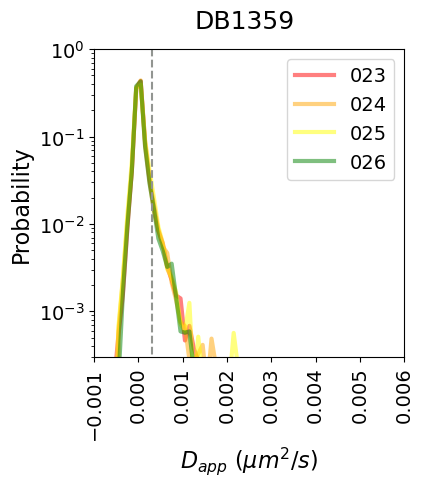

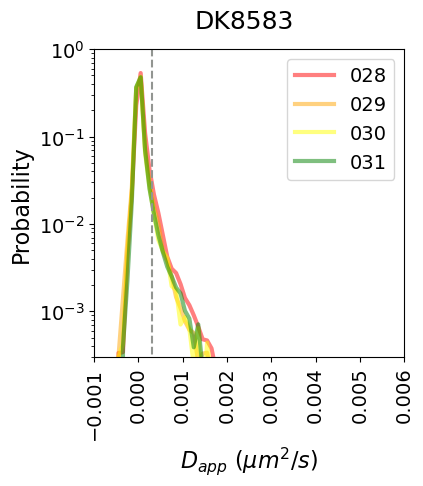

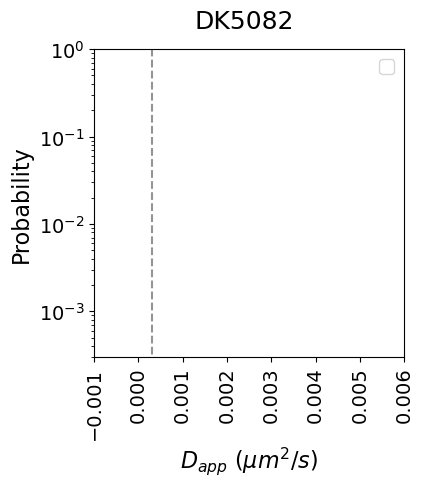

In [8]:
strains = ('Flask1', 'Flask2', 'Flask3')

folder = r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\fla-che induction\Inducible Water\2023-07-05_rois_g-r_radsym_cons_var-c'
fname = r'D_app_data.npy'

figfolder = r'D_app histograms'

if not os.path.exists(join(folder, figfolder)):
    os.makedirs(join(folder, figfolder))

D_app_data = np.load(join(folder, fname), allow_pickle=True).item()
allkeys = D_app_data['D_app'].keys()

min_locs = 20
n_bootlegs = 50 # I meant bootstraps, but dummy!
bins = np.arange(-0.004, 0.025, 0.0001)
mob_th = 0.0003 # mobility threshold

D_app_all = {}

for strain in strains:
    strainkeys = [key for key in allkeys if strain in key]
    D_app_all[strain] = {sk: {} for sk in strainkeys}
    for sk in strainkeys:
        D_app = D_app_data['D_app'][sk]
        ids = D_app_data['ids'][sk]
        D_app_bl = {nb: [] for nb in range(n_bootlegs)}
        ids_long = []
        n_locs_total = 0
        for i in np.unique(ids):
            n_locs = min_locs + (ids==i).sum() - 1
            n_locs_total += n_locs
            ids_long += [i]*n_locs
            
        n_samp = n_locs_total // min_locs
        for nb in range(n_bootlegs):
            randints = (np.random.uniform(size=n_samp) * len(ids_long)).astype('int')
            ids_samp = np.array(ids_long)[randints]
            D_app_bl[nb] = np.concatenate([np.random.choice(D_app[ids==ismp], size=(ids_samp==ismp).sum()) for ismp in np.unique(ids_samp)])
            D_app_all[strain][sk][nb] = D_app_bl[nb]

results = pd.DataFrame(columns=['movie', 'strain', 'n',
                                'f_mobile mean', 'f_mobile stdev', 'f_mobile median'],
                      index=range(len(allkeys))); j = 0
            
# strain = 'DK1906'
for strain in strains:
    # print(strain)
    movies = D_app_all[strain].keys()

    hists = {}

    for movie in movies:
        bootlegs = D_app_all[strain][movie].keys()
        hists[movie] = {}
        for bootleg in bootlegs:
            d_app = D_app_all[strain][movie][bootleg]
            hists[movie][bootleg] = np.histogram(d_app, bins=bins)[0]

    fig, ax = plt.subplots(1,1,figsize=(4,4))
    fig.suptitle(strain, fontsize=18)

    colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

    for i, m in enumerate(hists): # m: movie
        f_mob_bl = np.zeros(len(hists[m]))
        hnorm = np.zeros([len(hists[m]), len(hists[m][0])])
        for bl in hists[m]:
            hnorm[bl,:] = hists[m][bl] / hists[m][bl].sum()
            f_mob_bl[bl] = hnorm[bl][bins[:-1]>=mob_th].sum()
            # print(i, hists[m][bl].sum(), f_mob_bl.mean(), f_mob_bl.std(), np.median(f_mob_bl))
            # print(hnorm[bins[:-1]>=0.0003].sum())
        hnorm_mean = hnorm.mean(axis=0)
        ax.plot((bins[1:]+bins[:-1])/2, hnorm_mean, alpha=0.5, color=colors[i], label=Path(m).stem[-3:], lw=3)     
        
        results.loc[j, 'movie'] = m
        results.loc[j, 'strain'] = strain
        results.loc[j, 'n'] = hists[m][bl].sum()
        results.loc[j, 'f_mobile mean']  = f_mob_bl.mean()
        results.loc[j, 'f_mobile stdev'] = f_mob_bl.std()
        results.loc[j, 'f_mobile median'] = np.median(f_mob_bl)
        # print(results[j])
        j += 1
        
    ax.plot([mob_th, mob_th], [-1,1], '--', color='xkcd:gray')
    ax.set_xlim([-0.001, 0.006])
    ax.set_ylim([3e-4, 1])
    ax.set_yscale('log')
    plt.legend(loc='upper right', fontsize=14)
    plt.xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=16)
    plt.ylabel('Probability', fontsize=16)

    plt.xticks(fontsize=14, rotation='vertical')
    plt.yticks(fontsize=14);
    
    plt.savefig(join(folder, figfolder, strain+'.png'),
               dpi=450,
               bbox_inches='tight',
               transparent=True)
    
results.to_csv(join(folder, 'mobility results.csv'))